In [ ]:
'''
### Important before running this notebook!

- This notebook must be placed inside the TimesFM repository. 
- Do not copy or run it outside of the repo — it depends on the repository structure (notebooks/, external/, utils/, etc.).
To run: 
1. Clone the repository: git clone https://github.com/google-research/timesfm.git
                         cd timesfm
2. Put this notebook inside of the origin folder of repository
3. Make sure you have internet access (needed to install dependencies and download pretrained checkpoints)
'''

In [ ]:
!pip install -q huggingface_hub

from huggingface_hub import login, whoami, hf_hub_download

login(token="") #your token

In [5]:
!pip install -q "huggingface_hub>=0.23.0"

from huggingface_hub import login, snapshot_download
from huggingface_hub.utils import logging as hf_logging
hf_logging.set_verbosity_debug()

login(token = "") # your token

repo_id = "google/timesfm-2.0-500m-pytorch"
local_dir = "timesfm-2.0-500m-pytorch"

paths = snapshot_download(
    repo_id = repo_id,
    local_dir = local_dir,
    local_dir_use_symlinks = False,
    resume_download = True,
    max_workers = 4,
)
print(local_dir)


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Request eceb9655-bb41-4c80-8e7f-a9fee66f48ff: GET https://huggingface.co/api/whoami-v2 (authenticated: True)
Token is valid (permission: fineGrained).
The token `timesfm-access` has been saved to /Users/dmitry/.cache/huggingface/stored_tokens
Your token has been saved to /Users/dmitry/.cache/huggingface/token
Login successful.
The current active token is: `timesfm-access`
Request 63e90595-eb02-4b29-a049-e0f76d1b8352: GET https://huggingface.co/api/models/google/timesfm-2.0-500m-pytorch/revision/main (authenticated: True)
Request e62153b4-9e2e-4b4c-b365-79e82200f923: HEAD https://huggingface.co/google/timesfm-2.0-500m-pytorch/resolve/dc2443792ce5516872b89b37cf1bc058c3bf0c10/model.safetensors (authenticated: True)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Request 045d1739-7eed-464e-a963-10117999c472: HEAD https://huggingface.co/google/timesfm-2.0-500m-pytorch/resolve/dc2443792ce5516872b89b37cf1bc058c3bf0c10/torch_model.ckpt (authenticated: True)
Xet Storage is enabled for this repo. Downloading file from Xet Storage..
Request ed51ac96-cc5b-4ce7-91ac-2c2a480858b8: GET https://huggingface.co/api/models/google/timesfm-2.0-500m-pytorch/xet-read-token/dc2443792ce5516872b89b37cf1bc058c3bf0c10 (authenticated: True)


torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo. Downloading file from Xet Storage..
Request 9146bd0b-ee7e-4112-9cc9-e9f846b39767: GET https://huggingface.co/api/models/google/timesfm-2.0-500m-pytorch/xet-read-token/dc2443792ce5516872b89b37cf1bc058c3bf0c10 (authenticated: True)


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Download complete. Moving file to timesfm-2.0-500m-pytorch/torch_model.ckpt
Download complete. Moving file to timesfm-2.0-500m-pytorch/model.safetensors


Загружено в: timesfm-2.0-500m-pytorch


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

In [3]:
#Берем синтетические данные, анлогичные, как они были созданы для chronos
def generate_univariate_data(n=1000, T=12, n_anomalies=0, max_anomaly_size=5, n_normal_start=100):
    t = np.arange(n)
    t0 = np.random.randint(0, T)
    x = np.sin(2 * np.pi / T * (t + t0))  # Только синусоида, так как модель поддерживает только одномерные временные ряды
    y = np.zeros(n)

    for k in range(n_anomalies):
        i_start = np.random.randint(n_normal_start, n)
        i_end = i_start + np.random.randint(1, max_anomaly_size + 1)
        level = np.random.rand()
        x[i_start:i_end] = level
        y[i_start:i_end] = 1

    return x.reshape(-1, 1), y

In [4]:
X_normal, y_normal = generate_univariate_data(n=500, n_anomalies=0)
X_attack, y_attack = generate_univariate_data(n=500, n_anomalies=10)

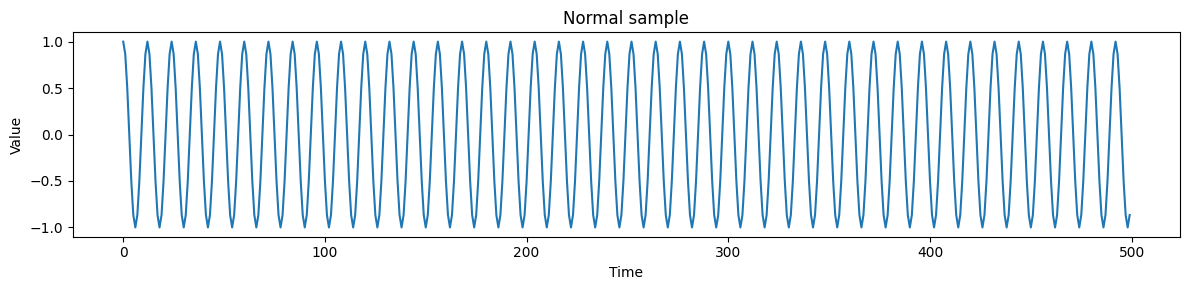

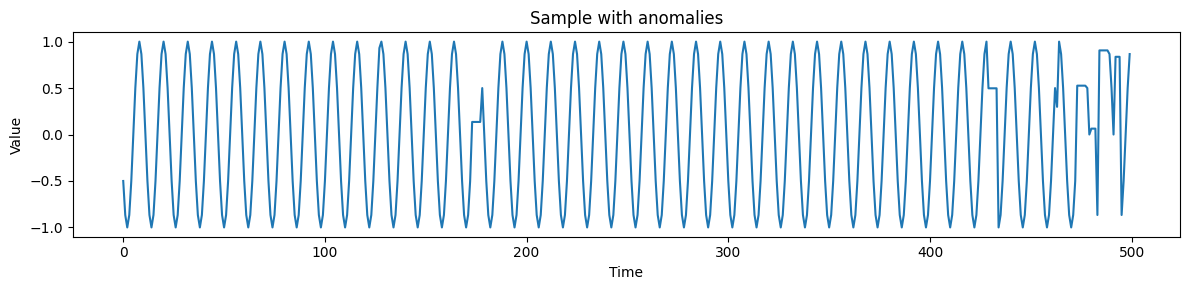

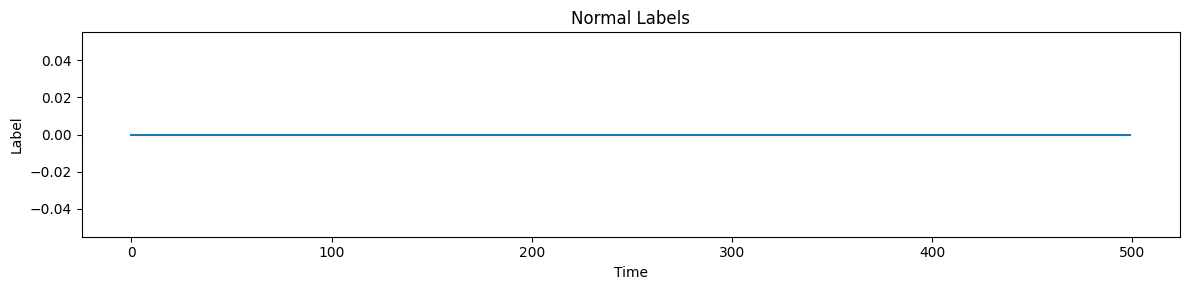

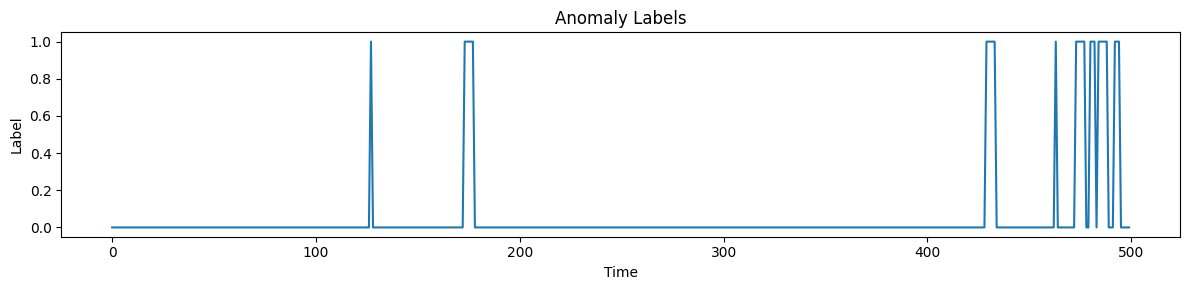

In [5]:
# Визуализация нормального ряда
plt.figure(figsize=(12, 3))
plt.plot(X_normal)
plt.title("Normal sample")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

# Визуализация ряда с аномалиями
plt.figure(figsize=(12, 3))
plt.plot(X_attack)
plt.title("Sample with anomalies")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

# Метки без аномалий
plt.figure(figsize=(12, 3))
plt.plot(y_normal)
plt.title("Normal Labels")
plt.xlabel("Time")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

# Метки аномалий
plt.figure(figsize=(12, 3))
plt.plot(y_attack)
plt.title("Anomaly Labels")
plt.xlabel("Time")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

In [6]:
import timesfm

ckpt_dir = "timesfm-2.0-500m-pytorch"
prediction_len = 10
context_len = 80

tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend = "pytorch",
        per_core_batch_size = 1,
        horizon_len = prediction_len,
        input_patch_len = 32,
        output_patch_len = 128,
        num_layers = 50,
        model_dims = 1280,
        use_positional_embedding = False,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id = "google/timesfm-2.0-500m-pytorch",
        local_dir = ckpt_dir                                     
    ),
)

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.10.9 (main, Mar  5 2025, 11:33:57) [Clang 14.0.3 (clang-1403.0.22.14.1)].


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
context_len = 80
prediction_len = 10
step = 5 

100%|███████████████████████████████████████████| 83/83 [00:11<00:00,  6.94it/s]


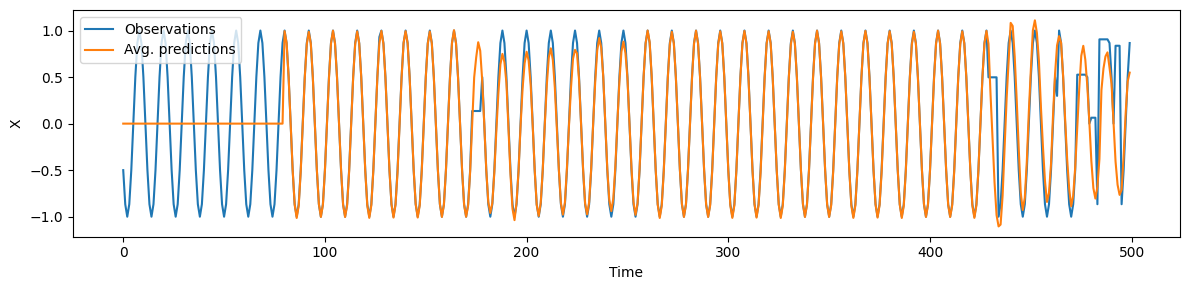

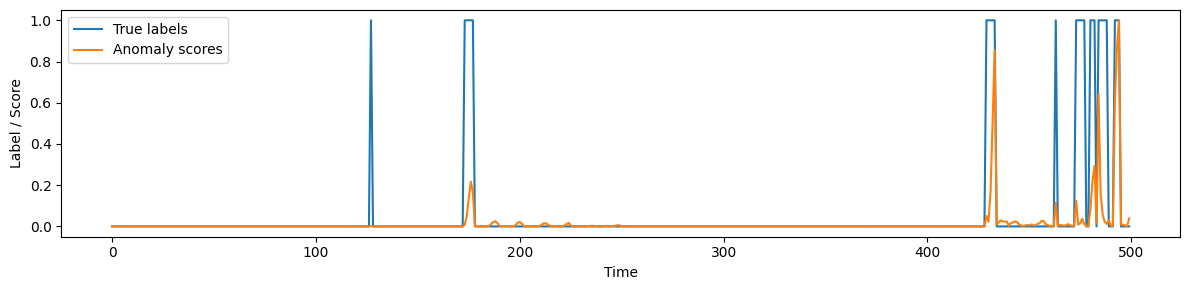

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def timesfm_predict_point(tfm, context_1d: np.ndarray, horizon: int, freq_code: int = 0) -> np.ndarray:
    ctx = np.asarray(context_1d, dtype=np.float32).copy()
    point_fcst, quant_fcst = tfm.forecast([ctx], freq=[freq_code])
    return np.asarray(point_fcst[0], dtype=np.float32)

X_pred = np.zeros_like(X_attack, dtype=np.float32)
anomaly_scores = np.zeros(len(X_attack), dtype=np.float32)
counts = np.zeros(len(X_attack), dtype=np.float32)

for start in tqdm(range(0, len(X_attack) - context_len - prediction_len + 1, step)):
    end_ctx = start + context_len
    end_all = end_ctx + prediction_len

    ax_context = X_attack[start:end_ctx, 0]
    ax_target = X_attack[end_ctx:end_all, 0]

    ax_pred = timesfm_predict_point(tfm, ax_context, prediction_len, freq_code=0)

    ax_err = (ax_target.astype(np.float32) - ax_pred) ** 2

    X_pred[end_ctx:end_all, 0] += ax_pred
    anomaly_scores[end_ctx:end_all] += ax_err
    counts[end_ctx:end_all] += 1

eps = 1e-6
mask = counts > 0
X_pred[mask, 0] /= (counts[mask] + eps)
anomaly_scores[mask] /= (counts[mask] + eps)

plt.figure(figsize=(12, 3))
plt.plot(X_attack[:, 0], label='Observations')
plt.plot(X_pred[:, 0], label='Avg. predictions')
plt.xlabel('Time'); plt.ylabel('X'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 3))
plt.plot(y_attack, label='True labels')
plt.plot(anomaly_scores / (anomaly_scores.max() + eps), label='Anomaly scores')
plt.xlabel('Time'); plt.ylabel('Label / Score'); plt.legend(); plt.tight_layout(); plt.show()

In [9]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import numpy as np

y_true = np.asarray(y_attack, dtype=np.float32).ravel()
scores = np.asarray(anomaly_scores, dtype=np.float32).ravel()

n = min(len(y_true), len(scores))
y_true = y_true[:n]
scores = scores[:n]

y_true_eval = y_true[context_len:]
scores_eval = scores[context_len:]

scores_norm = (scores_eval - scores_eval.min()) / (scores_eval.max() - scores_eval.min() + 1e-8)

best_f1, best_p, best_r, best_thr = 0, 0, 0, None
for thr in np.linspace(0, 1, 200):
    y_pred = (scores_norm >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_true_eval, y_pred, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_p, best_r, best_thr = f1, p, r, thr

roc_auc = roc_auc_score(y_true_eval, scores_norm)

print("Best threshold search:")
print(f"threshold={best_thr:.3f} | precision={best_p:.5f} | recall={best_r:.5f} | f1={best_f1:.5f} | roc_auc={roc_auc:.5f}")

Best threshold search:
threshold=0.030 | precision=0.95238 | recall=0.71429 | f1=0.81633 | roc_auc=0.97850
